#**Previsão do Número de Crimes nas diferentes áreas da Cidade de Los Angeles**

Este trabalho foi realizado para a unidade curricular de Big Data do mestrado em Análise de Dados e Sistemas de Apoio à Decisão.

**Autores:**

Catarina Auxiliar Nº 2021134297

Diogo Machado Nº 2020153309

João Leal Nº 2021130506

Ana Silva Nº 2018074120

### **Introdução aos Dados**  

Os dados utilizados nesta análise foram obtidos a partir do conjunto de dados **"USA Big City Crime Data"**, disponível no **Kaggle** ([fonte](https://www.kaggle.com/datasets/middlehigh/los-angeles-crime-data-from-2000?resource=download&select=Crime_Data_from_2020_to_Present.csv)). Este dataset contém informações detalhadas sobre crimes ocorridos em diversas grandes cidades dos Estados Unidos, incluindo **Los Angeles**.  

#### **Domínio e Contexto**  
O dataset de Los Angeles inclui registos criminais coletados entre **2000 e maio de 2024**, disponibilizados pela polícia local. Esses dados são de **domínio público (CC0: Public Domain)**.

---

#1. Preâmbulo

Importação das bibliotecas e criação da sessão spark.

In [2]:
pip install seaborn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# 1. Importação das bibliotecas

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, min, max, variance, when, month, dayofweek, hour, minute, year, to_timestamp, to_date
from pyspark.sql.functions import concat, lit, substring, lpad, format_string, sum, when, trim, upper, desc
from pyspark.sql.functions import unix_timestamp, datediff
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import folium
from folium.plugins import HeatMap
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# 2. Configuração do Spark


spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .appName("CrimeDataAnalysis_Fase2") \
    .getOrCreate()

# 3. Carregamento do Dataset

file_path = "/content/drive/My Drive/Crime_Data_from_2020_to_Present.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Configurar o Spark para evitar erro de parsing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# 2. Dados

Este capítulo tem o objetivo de fazer uma introdução aos dados, bem como visualizar as características do dataset.

In [5]:
# Exibir a estrutura do dataset

df.show(5)

+---------+--------------------+--------------------+--------+----+---------+-----------+--------+------+--------------------+-------------------+--------+--------+------------+---------+--------------------+--------------+-----------+------+------------+--------+--------+--------+--------+--------------------+------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|            Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+---------+-----------+--------+------+--------------------+-------------------+--------+--------+------------+---------+--------------------+--------------+-----------+------+------------+--------+--------+--------+--------+--------------------+

In [6]:
# Obter o número de linhas e colunas
num_rows = df.count()
num_cols = len(df.columns)
print(f"O dataset tem {num_rows} linhas e {num_cols} colunas.")

O dataset tem 944235 linhas e 28 colunas.


In [7]:
# Verificar os tipos de dados das colunas
df.printSchema()

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 1: integer (nullable = true)
 |-- Crm Cd 2: integer (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- L

# 3. Limpeza dos dados

## 3.1 Renomeação das variáveis

A renomeação das variáveis tem como objetivo permitir uma leitura mais clara e consequentemente, uma melhor perceção da informação. Deste modo, decidimos especificar os nomes das colunas.

In [8]:
# Renomear as colunas para melhor clareza
df_new = df.withColumnRenamed('Date Rptd', 'Date_Reported')\
               .withColumnRenamed('DATE OCC', 'Date_Occurred')\
               .withColumnRenamed('TIME OCC', 'Time_Occurred')\
               .withColumnRenamed('AREA', 'Area_Code')\
               .withColumnRenamed('AREA NAME', 'Area_Name')\
               .withColumnRenamed('Rpt Dist No', 'Report_District_Number')\
               .withColumnRenamed('Part 1-2', 'Part1_2_Indicator')\
               .withColumnRenamed('Crm Cd', 'Crime_Code')\
               .withColumnRenamed('Crm Cd Desc', 'Crime_Description')\
               .withColumnRenamed('Vict Age', 'Victim_Age')\
               .withColumnRenamed('Vict Sex', 'Victim_Sex')\
               .withColumnRenamed('Vict Descent', 'Victim_Descent')\
               .withColumnRenamed('Premis Cd', 'Premise_Code')\
               .withColumnRenamed('Status', 'Status_Code')\
               .withColumnRenamed('Status Desc', 'Status_Description')\
               .withColumnRenamed('Crm Cd 1', 'Crime_Code_1')\
               .withColumnRenamed('LOCATION', 'Location')\
               .withColumnRenamed('LAT', 'Latitude')\
               .withColumnRenamed('LON', 'Longitude')

# Primeiras linhas após as alterações
df_new.show(5)

+---------+--------------------+--------------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+-------------------+----------+----------+--------------+------------+--------------------+--------------+-----------+-----------+------------------+------------+--------+--------+--------+--------------------+------------+--------+---------+
|    DR_NO|       Date_Reported|       Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|   Crime_Description|            Mocodes|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|         Premis Desc|Weapon Used Cd|Weapon Desc|Status_Code|Status_Description|Crime_Code_1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            Location|Cross Street|Latitude|Longitude|
+---------+--------------------+--------------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+-------------------+----------+---

## 3.2 Conversão do formato de datas e horas

No dataset temos as colunas "Date_Reported" e "Date_Ocurred" com datas e horas, no entando decidimos retirar a hora e manter a data, uma vez que já existe uma coluna para as horas da ocorrência. Posteriormente as colunas de data foram convertidas para o formato datetime.

In [9]:
# Converter corretamente para timestamp (considerando a hora no formato AM/PM)
df_new = df_new.withColumn("Date_Reported", to_timestamp(col("Date_Reported"), "MM/dd/yyyy hh:mm:ss a"))
df_new = df_new.withColumn("Date_Occurred", to_timestamp(col("Date_Occurred"), "MM/dd/yyyy hh:mm:ss a"))

# Remover a hora e manter apenas a data
df_new = df_new.withColumn("Date_Reported", to_date(col("Date_Reported")))
df_new = df_new.withColumn("Date_Occurred", to_date(col("Date_Occurred")))

df_new.select("Date_Reported", "Date_Occurred").show(5)

+-------------+-------------+
|Date_Reported|Date_Occurred|
+-------------+-------------+
|   2020-03-01|   2020-03-01|
|   2020-02-09|   2020-02-08|
|   2020-11-11|   2020-11-04|
|   2023-05-10|   2020-03-10|
|   2022-08-18|   2020-08-17|
+-------------+-------------+
only showing top 5 rows



In [10]:
# Converter colunas de data para o formato datetime
df_new = df_new.withColumn("Date_Reported", to_date(col("Date_Reported"), "MM/dd/yyyy"))
df_new = df_new.withColumn("Date_Occurred", to_date(col("Date_Occurred"), "MM/dd/yyyy"))

df_new.show(7)

+---------+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+-------------------+----------+----------+--------------+------------+--------------------+--------------+-----------+-----------+------------------+------------+--------+--------+--------+--------------------+------------+--------+---------+
|    DR_NO|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|   Crime_Description|            Mocodes|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|         Premis Desc|Weapon Used Cd|Weapon Desc|Status_Code|Status_Description|Crime_Code_1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            Location|Cross Street|Latitude|Longitude|
+---------+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+-------------------+----------+----------+--------------+------------+------

Através da visualização da tabela, podemos observar que a coluna "Time_Occurred" está formatada em hora militar, pelo que vamos converter para o formato HH:MM. Além disso, alguns registos têm apenas três dígitos, e para evitar erros de formatação iremos adicionar um 0 à esquerda, conforme apresenta o código seguinte.

In [11]:
df_new = df_new.withColumn("Time_Occurred", lpad(col("Time_Occurred").cast("string"), 4, "0"))

df_new.show(truncate=False)

+---------+-------------+-------------+-------------+---------+-----------+----------------------+-----------------+----------+--------------------------------------------------------+----------------------------------+----------+----------+--------------+------------+--------------------------------------------+--------------+----------------------------------------------+-----------+------------------+------------+--------+--------+--------+----------------------------------------+-------------------------------+--------+---------+
|DR_NO    |Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name  |Report_District_Number|Part1_2_Indicator|Crime_Code|Crime_Description                                       |Mocodes                           |Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Premis Desc                                 |Weapon Used Cd|Weapon Desc                                   |Status_Code|Status_Description|Crime_Code_1|Crm Cd 2|Crm Cd 3|Crm Cd 4|Location     

In [12]:
# Substituir diretamente os valores na coluna "Time_Occurred" com o formato HH:MM

df_new = df_new.withColumn("Time_Occurred",
                           concat(substring(col("Time_Occurred"), 1, 2), lit(":"), substring(col("Time_Occurred"), 3, 2)))


df_new.select("Time_Occurred").show(10)

+-------------+
|Time_Occurred|
+-------------+
|        21:30|
|        18:00|
|        17:00|
|        20:37|
|        12:00|
|        23:00|
|        09:00|
|        11:10|
|        14:00|
|        12:20|
+-------------+
only showing top 10 rows



## 3.3 Tratamento de valores omissos

In [13]:
# Contar valores nulos em cada coluna
df_new.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_new.columns]).show()

+-----+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+-----------------+-------+----------+----------+--------------+------------+-----------+--------------+-----------+-----------+------------------+------------+--------+--------+--------+--------+------------+--------+---------+
|DR_NO|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|Crime_Description|Mocodes|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Premis Desc|Weapon Used Cd|Weapon Desc|Status_Code|Status_Description|Crime_Code_1|Crm Cd 2|Crm Cd 3|Crm Cd 4|Location|Cross Street|Latitude|Longitude|
+-----+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+-----------------+-------+----------+----------+--------------+------------+-----------+--------------+-----------+-----------+------------------+------------+--------+--------+----

In [14]:
# Remover colunas com muitos valores nulos e informação não relevante
columns_to_drop = ['Weapon Used Cd', 'Weapon Desc', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4',
                   'Cross Street', 'Premis Desc', 'Mocodes', 'DR_NO']

df_new = df_new.drop(*columns_to_drop)

# Mostrar as primeiras linhas
df_new.show(5)

+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+----------+----------+--------------+------------+-----------+------------------+------------+--------------------+--------+---------+
|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|   Crime_Description|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Status_Code|Status_Description|Crime_Code_1|            Location|Latitude|Longitude|
+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+----------+----------+--------------+------------+-----------+------------------+------------+--------------------+--------+---------+
|   2020-03-01|   2020-03-01|        21:30|        7| Wilshire|                   784|                1|       510|    VEHICLE - STOLEN|         0|         M|             O|         101| 

In [15]:
# Contar valores nulos após remoção de colunas
df_new.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_new.columns]).show()

+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+-----------------+----------+----------+--------------+------------+-----------+------------------+------------+--------+--------+---------+
|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|Crime_Description|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Status_Code|Status_Description|Crime_Code_1|Location|Latitude|Longitude|
+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+-----------------+----------+----------+--------------+------------+-----------+------------------+------------+--------+--------+---------+
|            0|            0|            0|        0|        0|                     0|                0|         0|                0|         0|    126595|        126605|          10|          0|                 0|          11|     

In [16]:
# Preencher valores nulos em 'Victim_Sex' e 'Victim_Descent' com 'X'
df_new = df_new.fillna({'Victim_Sex': 'X', 'Victim_Descent': 'X'})

In [17]:
# Remover linhas com valores nulos
df_new = df_new.dropna()

# Contar valores nulos novamente para confirmar
df_new.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_new.columns]).show()

+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+-----------------+----------+----------+--------------+------------+-----------+------------------+------------+--------+--------+---------+
|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|Crime_Description|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Status_Code|Status_Description|Crime_Code_1|Location|Latitude|Longitude|
+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+-----------------+----------+----------+--------------+------------+-----------+------------------+------------+--------+--------+---------+
|            0|            0|            0|        0|        0|                     0|                0|         0|                0|         0|         0|             0|           0|          0|                 0|           0|     

In [18]:
# Mostrar as primeiras linhas após as transformações
df_new.show(5)

+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+----------+----------+--------------+------------+-----------+------------------+------------+--------------------+--------+---------+
|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|   Crime_Description|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Status_Code|Status_Description|Crime_Code_1|            Location|Latitude|Longitude|
+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+----------+----------+--------------+------------+-----------+------------------+------------+--------------------+--------+---------+
|   2020-03-01|   2020-03-01|        21:30|        7| Wilshire|                   784|                1|       510|    VEHICLE - STOLEN|         0|         M|             O|         101| 

In [19]:
# voltar a contar o número de linhas e colunas para confirmar que não houve erros durante a eliminação de registos.

num_rows = df_new.count()
num_cols = len(df_new.columns)
print(f"O dataset tem {num_rows} linhas e {num_cols} colunas.")

O dataset tem 944214 linhas e 19 colunas.


## 3.4 Valores Únicos

Para confirmar que as variáveis estão conforme o suposto vamos confirmar os valores únicos em cada coluna.

In [20]:
# Identificar colunas categóricas e numéricas automaticamente
categorical_columns = [f.name for f in df_new.schema.fields if f.dataType.simpleString() == 'string']
numerical_columns = [f.name for f in df_new.schema.fields if f.dataType.simpleString() in ['int', 'double', 'float', 'bigint']]

print(f"📌 Colunas Categóricas: {categorical_columns}")
print(f"📌 Colunas Numéricas: {numerical_columns}")

# Criar dicionário para armazenar as contagens
unique_counts = {}

# Contar valores únicos para colunas categóricas
for col_name in categorical_columns:
    count = df_new.select(col_name).distinct().count()
    unique_counts[col_name] = count

# Contar valores únicos para colunas numéricas
for col_name in numerical_columns:
    count = df_new.select(col_name).distinct().count()
    unique_counts[col_name] = count

# Exibir os resultados
print("\n📊 Contagem de Valores Únicos por Coluna:")
for col_name, count in unique_counts.items():
    print(f"🔹 {col_name}: {count} valores únicos")

📌 Colunas Categóricas: ['Time_Occurred', 'Area_Name', 'Crime_Description', 'Victim_Sex', 'Victim_Descent', 'Status_Code', 'Status_Description', 'Location']
📌 Colunas Numéricas: ['Area_Code', 'Report_District_Number', 'Part1_2_Indicator', 'Crime_Code', 'Victim_Age', 'Premise_Code', 'Crime_Code_1', 'Latitude', 'Longitude']

📊 Contagem de Valores Únicos por Coluna:
🔹 Time_Occurred: 1439 valores únicos
🔹 Area_Name: 21 valores únicos
🔹 Crime_Description: 139 valores únicos
🔹 Victim_Sex: 5 valores únicos
🔹 Victim_Descent: 20 valores únicos
🔹 Status_Code: 6 valores únicos
🔹 Status_Description: 6 valores únicos
🔹 Location: 65694 valores únicos
🔹 Area_Code: 21 valores únicos
🔹 Report_District_Number: 1209 valores únicos
🔹 Part1_2_Indicator: 2 valores únicos
🔹 Crime_Code: 139 valores únicos
🔹 Victim_Age: 104 valores únicos
🔹 Premise_Code: 314 valores únicos
🔹 Crime_Code_1: 141 valores únicos
🔹 Latitude: 5422 valores únicos
🔹 Longitude: 4979 valores únicos


In [21]:
# O indicador Victim_Sex apresenta 5 valores únicos, quando deveria existir apenas 3 (F, M, X).

# Listar valores únicos da coluna 'Victim_Sex'
df_new.select("Victim_Sex").distinct().show(truncate=False)

+----------+
|Victim_Sex|
+----------+
|F         |
|M         |
|X         |
|H         |
|-         |
+----------+



In [22]:
# Tendo em conta que as categorias "H" e "-" representam erros, tomamos a decisão de trocar todos esses valores por 'X'.

# 1. Remover espaços extras e garantir que tudo está em maiúsculas
df_new = df_new.withColumn("Victim_Sex", trim(upper(col("Victim_Sex"))))

# 2. Substituir valores inválidos ("H" e "-") por "X"
df_new = df_new.withColumn("Victim_Sex",
    when(col("Victim_Sex").isin(["M", "F", "X"]), col("Victim_Sex"))  # Mantém os valores válidos
    .otherwise("X")  # Substitui tudo o que for diferente de "M", "F" ou "X"
)

# 3. Verificar se os valores foram corrigidos
df_new.select("Victim_Sex").distinct().show()

+----------+
|Victim_Sex|
+----------+
|         F|
|         M|
|         X|
+----------+



## 3.5 Duplicados

In [23]:
# Contar o número de linhas antes de remover duplicados
num_rows_before = df_new.count()

# Contar o número de linhas únicas, eliminando os duplicados
num_rows_unique = df_new.dropDuplicates().count()

# Calcular o número de duplicados
num_duplicated = num_rows_before - num_rows_unique

print(f"O dataset tem {num_rows_before} linhas antes da remoção de duplicados")
print(f"O dataset tem {num_duplicated} linhas duplicadas.")

O dataset tem 944214 linhas antes da remoção de duplicados
O dataset tem 3954 linhas duplicadas.


# 4. Transformação dos dados

## 4.1 Codificação das variáveis categóricas

Para saber se podemos utilizar o one-hot encoding, temos de perceber primeiro se existem muitas categorias para cada variável categórica. Caso existam devemos escolher outro método de codificação para evitar a maldição da dimensionalidade.

In [24]:
# Verificar os tipos de dados das colunas para escolher apenas as categóricas
df_new.printSchema()

root
 |-- Date_Reported: date (nullable = true)
 |-- Date_Occurred: date (nullable = true)
 |-- Time_Occurred: string (nullable = true)
 |-- Area_Code: integer (nullable = true)
 |-- Area_Name: string (nullable = true)
 |-- Report_District_Number: integer (nullable = true)
 |-- Part1_2_Indicator: integer (nullable = true)
 |-- Crime_Code: integer (nullable = true)
 |-- Crime_Description: string (nullable = true)
 |-- Victim_Age: integer (nullable = true)
 |-- Victim_Sex: string (nullable = false)
 |-- Victim_Descent: string (nullable = false)
 |-- Premise_Code: integer (nullable = true)
 |-- Status_Code: string (nullable = true)
 |-- Status_Description: string (nullable = true)
 |-- Crime_Code_1: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [25]:
#O primeiro passo é filtrar os valores únicos de cada coluna categórica

# Lista de variáveis categóricas
categorical_columns = ['Area_Name', 'Crime_Description', 'Victim_Sex',
                       'Victim_Descent', 'Status_Code', 'Status_Description', 'Location']

# Contar quantas categorias únicas existem em cada variável categórica
category_counts = {col_name: df_new.select(col_name).distinct().count() for col_name in categorical_columns}

# Mostrar os resultados
for col_name, count in category_counts.items():
    print(f"A coluna '{col_name}' tem {count} categorias únicas.")

A coluna 'Area_Name' tem 21 categorias únicas.
A coluna 'Crime_Description' tem 139 categorias únicas.
A coluna 'Victim_Sex' tem 3 categorias únicas.
A coluna 'Victim_Descent' tem 20 categorias únicas.
A coluna 'Status_Code' tem 6 categorias únicas.
A coluna 'Status_Description' tem 6 categorias únicas.
A coluna 'Location' tem 65694 categorias únicas.


### Solução ideal para cada coluna

1. Manter One Hot Encoding nas variáveis seguras

* Area_Name (21 categorias)\
* Crime_Description (139 categorias)\
* Victim_Sex (5 categorias)\
* Victim_Descent (20 categorias)\
* Status_Code (6 categorias)\
* Status_Description (6 categorias)

📌 Total esperado de colunas geradas → 197 novas colunas

2. Evitar One Hot Encoding na coluna Location

Alternativas: Utilizar o feature hashing.

In [26]:
#Aplicação do One Hot Encoding

# Definir as colunas categóricas que podem usar One Hot Encoding
categorical_cols = ['Area_Name', 'Crime_Description', 'Victim_Sex',
                    'Victim_Descent', 'Status_Code', 'Status_Description']

# Criar indexadores
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]

# Criar o One Hot Encoder
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_cols]

# Criar o pipeline para aplicar a transformação em sequência
pipeline = Pipeline(stages=indexers + encoders)

# Aplicar as transformações ao dataset
df_encoded = pipeline.fit(df_new).transform(df_new)

# Mostrar as colunas após a transformação
print("Colunas finais:", df_encoded.columns)

# Mostrar algumas linhas do dataset transformado
df_encoded.show(5)

Colunas finais: ['Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Area_Code', 'Area_Name', 'Report_District_Number', 'Part1_2_Indicator', 'Crime_Code', 'Crime_Description', 'Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Status_Code', 'Status_Description', 'Crime_Code_1', 'Location', 'Latitude', 'Longitude', 'Area_Name_index', 'Crime_Description_index', 'Victim_Sex_index', 'Victim_Descent_index', 'Status_Code_index', 'Status_Description_index', 'Area_Name_ohe', 'Crime_Description_ohe', 'Victim_Sex_ohe', 'Victim_Descent_ohe', 'Status_Code_ohe', 'Status_Description_ohe']
+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+----------+----------+--------------+------------+-----------+------------------+------------+--------------------+--------+---------+---------------+-----------------------+----------------+--------------------+-----------------+------------------------+---------------

## 4.2 Criação de features de datas

In [27]:
# Criar novas colunas "Month", "DayOfWeek" e "Hour" a partir de "Date_Occurred" e "Time_Occurred"
df_encoded = df_encoded.withColumn("Month", month(col("Date_Occurred")))
df_encoded = df_encoded.withColumn("DayOfWeek", dayofweek(col("Date_Occurred")))
df_encoded = df_encoded.withColumn("Hour", hour(col("Time_Occurred")))

# Verificar colunas disponíveis após a adição das novas features
print("Available columns after adding date features:", df_encoded.columns)

Available columns after adding date features: ['Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Area_Code', 'Area_Name', 'Report_District_Number', 'Part1_2_Indicator', 'Crime_Code', 'Crime_Description', 'Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Status_Code', 'Status_Description', 'Crime_Code_1', 'Location', 'Latitude', 'Longitude', 'Area_Name_index', 'Crime_Description_index', 'Victim_Sex_index', 'Victim_Descent_index', 'Status_Code_index', 'Status_Description_index', 'Area_Name_ohe', 'Crime_Description_ohe', 'Victim_Sex_ohe', 'Victim_Descent_ohe', 'Status_Code_ohe', 'Status_Description_ohe', 'Month', 'DayOfWeek', 'Hour']


## 4.3 Normalização de atributos numéricos

In [28]:
# Definir as colunas numéricas que vão ser normalizadas
numeric_cols = ["Victim_Age", "Latitude", "Longitude", "Month", "DayOfWeek", "Hour"]

# Criar um vetor com as colunas numéricas
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features", handleInvalid="skip")
vector_df = assembler.transform(df_encoded)

# Aplicar o StandardScaler para normalização
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df_scaled = scaler.fit(vector_df).transform(vector_df)

# Mostrar um exemplo das transformações
df_scaled.select("features", "scaled_features").show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[0.0,34.0375,-118...|[0.0,20.379188273...|
|[47.0,34.0444,-11...|[2.14787020477832...|
|[19.0,34.021,-118...|[0.86828795512315...|
|[19.0,34.1576,-11...|[0.86828795512315...|
|[28.0,34.0944,-11...|[1.27958224965517...|
+--------------------+--------------------+
only showing top 5 rows



## 4.4 Substituição das categorias da coluna Victim_Descent pelo seu respetivo nome

In [29]:
from pyspark.sql.functions import when, col

# Dicionário de mapeamento dos códigos para os nomes completos
descent_mapping = {
    "A": "Other Asian",
    "B": "Black",
    "C": "Chinese",
    "D": "Cambodian",
    "F": "Filipino",
    "G": "Guamanian",
    "H": "Hispanic/Latin/Mexican",
    "I": "American Indian/Alaskan Native",
    "J": "Japanese",
    "K": "Korean",
    "L": "Laotian",
    "O": "Other",
    "P": "Pacific Islander",
    "S": "Samoan",
    "U": "Hawaiian",
    "V": "Vietnamese",
    "W": "White",
    "X": "Unknown",
    "Z": "Asian Indian"
}

# Criar uma nova coluna substituindo os códigos pelos nomes completos
df_new = df_new.withColumn(
    "Victim_Descent",
    when(col("Victim_Descent") == "A", "Other Asian")
    .when(col("Victim_Descent") == "B", "Black")
    .when(col("Victim_Descent") == "C", "Chinese")
    .when(col("Victim_Descent") == "D", "Cambodian")
    .when(col("Victim_Descent") == "F", "Filipino")
    .when(col("Victim_Descent") == "G", "Guamanian")
    .when(col("Victim_Descent") == "H", "Hispanic/Latin/Mexican")
    .when(col("Victim_Descent") == "I", "American Indian/Alaskan Native")
    .when(col("Victim_Descent") == "J", "Japanese")
    .when(col("Victim_Descent") == "K", "Korean")
    .when(col("Victim_Descent") == "L", "Laotian")
    .when(col("Victim_Descent") == "O", "Other")
    .when(col("Victim_Descent") == "P", "Pacific Islander")
    .when(col("Victim_Descent") == "S", "Samoan")
    .when(col("Victim_Descent") == "U", "Hawaiian")
    .when(col("Victim_Descent") == "V", "Vietnamese")
    .when(col("Victim_Descent") == "W", "White")
    .when(col("Victim_Descent") == "X", "Unknown")
    .when(col("Victim_Descent") == "Z", "Asian Indian")
    .otherwise("Unknown")  # Caso apareça um código não listado
)

# Verificar se os valores foram substituídos corretamente
df_new.select("Victim_Descent").distinct().show()

+--------------------+
|      Victim_Descent|
+--------------------+
|        Asian Indian|
|American Indian/A...|
|             Chinese|
|            Hawaiian|
|            Japanese|
|Hispanic/Latin/Me...|
|             Unknown|
|            Filipino|
|          Vietnamese|
|               Other|
|    Pacific Islander|
|              Samoan|
|           Guamanian|
|              Korean|
|             Laotian|
|               White|
|           Cambodian|
|               Black|
|         Other Asian|
+--------------------+



# 5. Análise e exploração dos dados

## Estatísticas descritivas

In [30]:
# Descrição dos dados

df_encoded.describe().show()

+-------+-------------+------------------+-----------+----------------------+-------------------+------------------+--------------------+------------------+----------+--------------+------------------+-----------+------------------+------------------+--------------------+-----------------+-------------------+-----------------+-----------------------+------------------+--------------------+-------------------+------------------------+-----------------+-----------------+-----------------+
|summary|Time_Occurred|         Area_Code|  Area_Name|Report_District_Number|  Part1_2_Indicator|        Crime_Code|   Crime_Description|        Victim_Age|Victim_Sex|Victim_Descent|      Premise_Code|Status_Code|Status_Description|      Crime_Code_1|            Location|         Latitude|          Longitude|  Area_Name_index|Crime_Description_index|  Victim_Sex_index|Victim_Descent_index|  Status_Code_index|Status_Description_index|            Month|        DayOfWeek|             Hour|
+-------+-------

In [31]:
# Verificar os tipos de dados de dados das colunas do DataFrame
df_encoded.printSchema() #Mostra a estrutura do DataFrame, incluindo tipos de dados e valores nulos

root
 |-- Date_Reported: date (nullable = true)
 |-- Date_Occurred: date (nullable = true)
 |-- Time_Occurred: string (nullable = true)
 |-- Area_Code: integer (nullable = true)
 |-- Area_Name: string (nullable = true)
 |-- Report_District_Number: integer (nullable = true)
 |-- Part1_2_Indicator: integer (nullable = true)
 |-- Crime_Code: integer (nullable = true)
 |-- Crime_Description: string (nullable = true)
 |-- Victim_Age: integer (nullable = true)
 |-- Victim_Sex: string (nullable = false)
 |-- Victim_Descent: string (nullable = false)
 |-- Premise_Code: integer (nullable = true)
 |-- Status_Code: string (nullable = true)
 |-- Status_Description: string (nullable = true)
 |-- Crime_Code_1: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Area_Name_index: double (nullable = false)
 |-- Crime_Description_index: double (nullable = false)
 |-- Victim_Sex_index: double (nullable = f

In [32]:
# Selecionar colunas numéricas para a análise estatística
numeric_cols = [
    "Area_Code", "Report_District_Number", "Part1_2_Indicator",
    "Crime_Code", "Victim_Age", "Premise_Code",
    "Status_Code", "Crime_Code_1"
]

# Mostrar as colunas selecionas
print("Colunas Numéricas Selecionadas:", numeric_cols)

Colunas Numéricas Selecionadas: ['Area_Code', 'Report_District_Number', 'Part1_2_Indicator', 'Crime_Code', 'Victim_Age', 'Premise_Code', 'Status_Code', 'Crime_Code_1']


In [33]:
#  Cálculo das estatísticas para as colunas numéricas
stats = df_encoded.select(
    [mean(c).alias(f"Média_{c}") for c in numeric_cols] + #Média
    [stddev(c).alias(f"DesvioPadrão_{c}") for c in numeric_cols] + # Desvio Padrão
    [min(c).alias(f"Mínimo_{c}") for c in numeric_cols] + #Valor Mínimo
    [max(c).alias(f"Máximo_{c}") for c in numeric_cols] + #Valor Máximo
    [variance(c).alias(f"Variância_{c}") for c in numeric_cols] #Variância
).collect()[0] # Recolha de valores para dicionário

# Criar dicionários para armazenar os valores
estatisticas = {
    "Média": {},
    "Desvio Padrão": {},
    "Mínimo": {},
    "Máximo": {},
    "Variância": {},
    "Moda": {}
}

# Separar os valores corretamente e tratar de Volores None
for i, c in enumerate(numeric_cols):
    estatisticas["Média"][c] = stats[i] if stats[i] is not None else "N/A"
    estatisticas["Desvio Padrão"][c] = stats[i + len(numeric_cols)] if stats[i + len(numeric_cols)] is not None else "N/A"
    estatisticas["Mínimo"][c] = stats[i + 2 * len(numeric_cols)] if stats[i + 2 * len(numeric_cols)] is not None else "N/A"
    estatisticas["Máximo"][c] = stats[i + 3 * len(numeric_cols)] if stats[i + 3 * len(numeric_cols)] is not None else "N/A"
    estatisticas["Variância"][c] = stats[i + 4 * len(numeric_cols)] if stats[i + 4 * len(numeric_cols)] is not None else "N/A"

    #  Cálculo da Moda (valor mais frequente)
    moda_df = df_encoded.groupBy(c).count().orderBy(desc("count"))
    moda_row = moda_df.first()  # Valor mais frequente
    estatisticas["Moda"][c] = moda_row[0] if moda_row else "N/A"

# Mostrar os valores formatados corretamente
for key, valores in estatisticas.items():
    print(f"\n{key}:")
    for coluna, valor in valores.items():
        if isinstance(valor, (int, float)):  # Formatar os números com 2 casas decimais
            print(f"{coluna} = {valor:.2f}")
        else:
            print(f"{coluna} = {valor}")  # Exibir "N/A" diretamente



Média:
Area_Code = 10.72
Report_District_Number = 1118.56
Part1_2_Indicator = 1.41
Crime_Code = 500.81
Victim_Age = 29.50
Premise_Code = 306.55
Status_Code = N/A
Crime_Code_1 = 500.56

Desvio Padrão:
Area_Code = 6.10
Report_District_Number = 609.97
Part1_2_Indicator = 0.49
Crime_Code = 207.28
Victim_Age = 21.88
Premise_Code = 217.56
Status_Code = N/A
Crime_Code_1 = 207.08

Mínimo:
Area_Code = 1.00
Report_District_Number = 101.00
Part1_2_Indicator = 1.00
Crime_Code = 110.00
Victim_Age = -4.00
Premise_Code = 101.00
Status_Code = AA
Crime_Code_1 = 110.00

Máximo:
Area_Code = 21.00
Report_District_Number = 2199.00
Part1_2_Indicator = 2.00
Crime_Code = 956.00
Victim_Age = 120.00
Premise_Code = 976.00
Status_Code = JO
Crime_Code_1 = 956.00

Variância:
Area_Code = 37.20
Report_District_Number = 372060.04
Part1_2_Indicator = 0.24
Crime_Code = 42966.46
Victim_Age = 478.83
Premise_Code = 47332.67
Status_Code = N/A
Crime_Code_1 = 42881.05

Moda:
Area_Code = 1.00
Report_District_Number = 162.00
P

**Resumo da Análise Estatística das Variáveis**

* **Idade das Vítimas:** A variável Victim_Age tem uma média de 29,5 anos e um desvio padrão de 21,88, indicando grande variação na idade das vítimas;

* **Tipos de Crimes:** A variável Crime_Code tem uma média de 500,8, sugerindo um possível padrão nos crimes registados;
* **Distribuição por Distrito:** A variável Report_District_Number apresenta uma média de 1118,56 e um desvio padrão de 609,96, indicando que os crimes ocorrem em diferentes distritos com frequências variáveis;
* **Intervalo de Crime_Code:** Os crimes registados variam entre os códigos 110 e 956, confirmando a diversidade dos crimes praticados;
* **Crimes Mais Frequentes:** A moda indica que o crime mais comum está associado ao código 510 e que o distrito policial com maior número de registos é o 162;
* **Mínimos:** A análise dos valores mínimos revelou que a variável *Victim_Age* apresenta um valor de -4, o que não é plausível. Esse erro será corrigido para garantir a coerência dos dados e a precisão da análise;
* **Máximos:** Os valores máximos das variáveis indicam os limites superiores dos dados registados. Destaca-se a variável *Victim_Age*, que apresenta um valor máximo de 120 anos, sendo um possível outlier ou erro de registo. Além disso, observamos que o *Crime_Code* atinge um máximo de 956, sugerindo a diversidade de crimes documentados no dataset.

In [34]:
#Remover registos inválidos registados como negativos
df_encoded = df_encoded.filter(df_encoded.Victim_Age>=0)

## Deteção de outliers na idade da vítima

In [35]:
#  Verificar se a coluna "Victim_Age" existe
if "Victim_Age" not in df_encoded.columns:
    raise ValueError("A coluna 'Victim_Age' não existe no DataFrame!")

#  Remover valores NULL antes de calcular o IQR ( Intervalo interquartil)
df_encoded = df_encoded.na.drop(subset=["Victim_Age"])

#  Cálculo do IQR (Intervalo Interquartil)
Q1 = df_encoded.approxQuantile("Victim_Age", [0.25], 0)[0]
Q3 = df_encoded.approxQuantile("Victim_Age", [0.75], 0)[0]
IQR = Q3 - Q1

# Definição dos limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtro nas vitimas cuja idade esteja fora dos limites estabelecidos
outliers = df_encoded.filter((col("Victim_Age") < lower_bound) | (col("Victim_Age") > upper_bound))

#  Mostrar resultados
print(f"Outliers encontrados: {outliers.count()}")
outliers.show(5)

Outliers encontrados: 1
+-------------+-------------+-------------+---------+---------+----------------------+-----------------+----------+--------------------+----------+----------+--------------+------------+-----------+------------------+------------+--------------------+--------+---------+---------------+-----------------------+----------------+--------------------+-----------------+------------------------+---------------+---------------------+--------------+------------------+---------------+----------------------+-----+---------+----+
|Date_Reported|Date_Occurred|Time_Occurred|Area_Code|Area_Name|Report_District_Number|Part1_2_Indicator|Crime_Code|   Crime_Description|Victim_Age|Victim_Sex|Victim_Descent|Premise_Code|Status_Code|Status_Description|Crime_Code_1|            Location|Latitude|Longitude|Area_Name_index|Crime_Description_index|Victim_Sex_index|Victim_Descent_index|Status_Code_index|Status_Description_index|  Area_Name_ohe|Crime_Description_ohe|Victim_Sex_ohe|Victim_D

In [36]:
# Criar um novo DataFrame sem os outliers
df_encoded = df_encoded.filter((col("Victim_Age") >= lower_bound) & (col("Victim_Age") <= upper_bound))

## Matriz de Correlação  das Variáveis Numéricas

### Criação de Novas Features no Dataset

In [37]:
# Criar novas colunas temporais
df_new = df_new.withColumn("Ano", year(col("Date_Occurred")))
df_new = df_new.withColumn("Mes", month(col("Date_Occurred")))
df_new = df_new.withColumn("DiaSemana", dayofweek(col("Date_Occurred")))
df_new = df_new.withColumn("Hora", hour(col("Time_Occurred")))
df_new = df_new.withColumn("FinsDeSemana", when(col("DiaSemana").isin([1, 7]), 1).otherwise(0)) #Sábado ou Domingo

# Verificar se as colunas foram criadas corretamente
df_new.select("Ano", "Mes", "DiaSemana", "Hora", "FinsDeSemana").show(10)

+----+---+---------+----+------------+
| Ano|Mes|DiaSemana|Hora|FinsDeSemana|
+----+---+---------+----+------------+
|2020|  3|        1|  21|           1|
|2020|  2|        7|  18|           1|
|2020| 11|        4|  17|           0|
|2020|  3|        3|  20|           0|
|2020|  8|        2|  12|           0|
|2020| 12|        3|  23|           0|
|2020|  7|        6|   9|           0|
|2020|  5|        3|  11|           0|
|2020| 12|        4|  14|           0|
|2020| 12|        5|  12|           0|
+----+---+---------+----+------------+
only showing top 10 rows



A partir das colunas *Date_Occurred* e *Time_Occurred*, foram extraídas novas variáveis que permitem uma análise mais detalhada dos padrões temporais dos crimes;

* **Divisão Temporal:** Foram criadas colunas representando o ano, mês, dia da semana e hora em que o crime ocorreu, possibilitando visualizar como a criminalidade se distribui ao longo do tempo;
* **Identificação de Fins de Semana:** Criou-se uma variável categórica para indicar se o crime ocorreu em um dia útil ou no fim de semana, permitindo comparações entre dias de maior e menor fluxo populacional;
* **Interpretação dos Dias da Semana:** No dataset, os dias da semana são representados por números, onde *1* corresponde à segunda-feira e *7* ao domingo, facilitando futuras análises e visualizações gráficas.

### Matriz de correlação

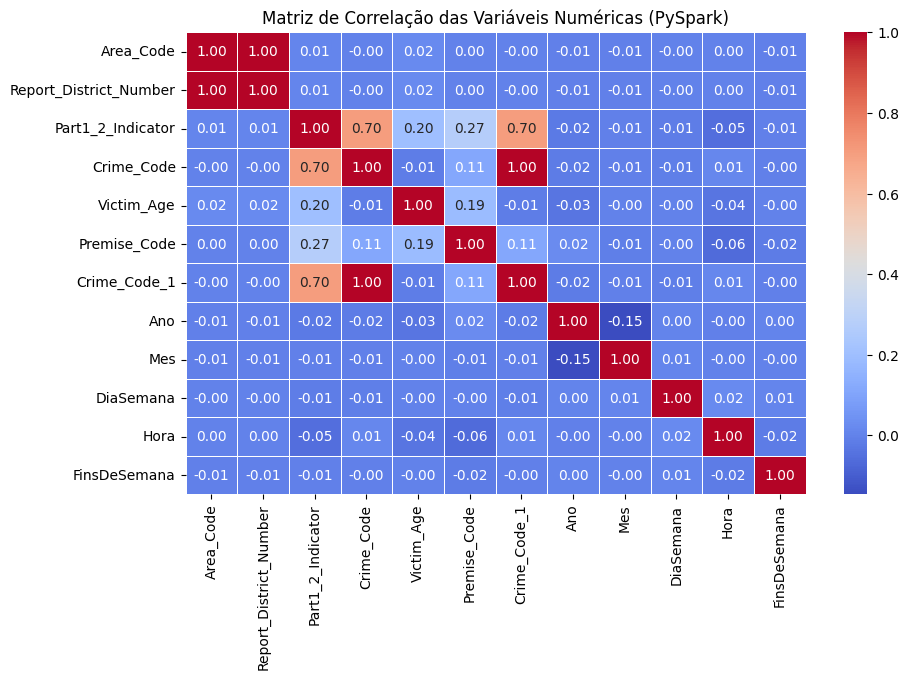

In [38]:
# Definir as colunas numéricas para análise de correlação
numeric_cols = ["Area_Code", "Report_District_Number", "Part1_2_Indicator", "Crime_Code", "Victim_Age", "Premise_Code", "Crime_Code_1", "Ano", "Mes","DiaSemana","Hora", "FinsDeSemana" ]

# Criar o vetor de características para a correlação
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df_new).select(vector_col)

# Calcular a matriz de correlação
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Converter para array numpy
corr_array = np.array(correlation_matrix.toArray())

# Criar o heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Matriz de Correlação das Variáveis Numéricas (PySpark)")
plt.show()

### **Resumo da Análise de Correlação**  

* **Seleção das Variáveis Numéricas:** Foram escolhidas as variáveis mais relevantes, incluindo *Area_Code, Report_District_Number, Part1_2_Indicator, Crime_Code, Victim_Age, Premise_Code, Crime_Code_1, Ano, Mês, DiaSemana, Hora* e *FinsDeSemana*;  

* **Principais Correlações Encontradas:**  
  - *Part1_2_Indicator* e *Crime_Code* apresentam uma correlação forte (0.70), sugerindo que crimes mais graves possuem códigos distintos dos menos graves;  
  - *Premise_Code* e *Victim_Age* possuem uma correlação de 0.19, indicando que a idade da vítima pode estar relacionada ao local do crime (ex.: escolas com vítimas jovens, lares de idosos com vítimas mais velhas);
* **Correlação das Variáveis Temporais:** As variáveis temporais (*Ano, Mês, DiaSemana, Hora, FinsDeSemana*) não apresentam correlações significativas com outras variáveis.

## 5.1 Análise dos crimes

### Distruibuição dos crimes mais frequentes

In [39]:
print(count)  # Se isto mostrar um número, está a dar overwrite à função!

65694


In [42]:
#  Contar o número de ocorrências por tipo de crime
df_crime_freq = df_new.groupBy("Crime_Description").agg(count("*").alias("Crime_Count"))

#  Ordenar os crimes do mais frequente para o menos frequente
df_crime_freq = df_crime_freq.orderBy(col("Crime_Count").desc())

#  Mostrar os 10 crimes mais comuns
df_crime_freq.show(10)

+--------------------+-----------+
|   Crime_Description|Crime_Count|
+--------------------+-----------+
|    VEHICLE - STOLEN|     102034|
|BATTERY - SIMPLE ...|      74509|
|BURGLARY FROM VEH...|      58309|
|   THEFT OF IDENTITY|      58240|
|            BURGLARY|      57497|
|VANDALISM - FELON...|      57193|
|ASSAULT WITH DEAD...|      53192|
|THEFT PLAIN - PET...|      48215|
|INTIMATE PARTNER ...|      46631|
|THEFT FROM MOTOR ...|      36611|
+--------------------+-----------+
only showing top 10 rows



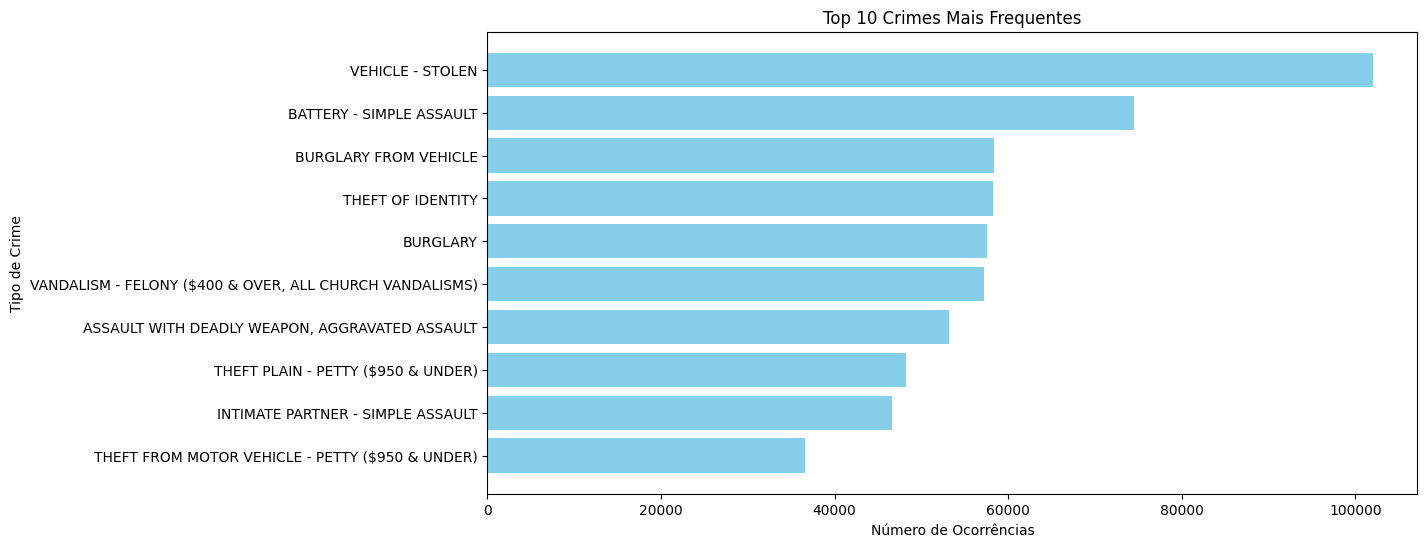

In [43]:
# Converter para Pandas para visualização
df_pandas = df_crime_freq.limit(10).toPandas()

# Criar gráfico de barras
plt.figure(figsize=(12,6))
plt.barh(df_pandas["Crime_Description"], df_pandas["Crime_Count"], color="skyblue")
plt.xlabel("Número de Ocorrências")
plt.ylabel("Tipo de Crime")
plt.title("Top 10 Crimes Mais Frequentes")
plt.gca().invert_yaxis()  # Inverter a ordem para o mais frequente aparecer no topo
plt.show()

### **Resumo da Análise dos Crimes Mais Comuns**  

A tabela gerada apresenta a descrição dos crimes e o número de ocorrências registadas

* **Crime Mais Frequente:** O **roubo de veículos** é o crime mais comum na cidade, com mais de 102.034 registos;  
* **Relevância para a Segurança Pública:** Com base nesses dados, as forças de segurança podem adotar **estratégias mais eficientes** para combater os crimes mais recorrentes, focando-se nas áreas com maior incidência, promovendo assim a segurança da população.

### Distribuição de crimes por distrito

In [44]:
# Contar o número de crimes por distrito policial
df_crime_area = df_new.groupBy("Report_District_Number").agg(count("*").alias("Crime_Count"))

# Ordenar as áreas com mais crimes
df_crime_area = df_crime_area.orderBy(col("Crime_Count").desc())

# Mostrar os 10 distritos com mais crimes
df_crime_area.show(10)

+----------------------+-----------+
|Report_District_Number|Crime_Count|
+----------------------+-----------+
|                   162|       4973|
|                   645|       4684|
|                  1494|       4519|
|                   182|       4480|
|                   646|       4156|
|                  2156|       3753|
|                   636|       3749|
|                   111|       3608|
|                  1822|       3101|
|                   152|       2931|
+----------------------+-----------+
only showing top 10 rows



In [45]:
#  Contar crimes por nome da área
if "Area_Name" in df_new.columns:
    df_crime_area_name = df_new.groupBy("Area_Name").agg(count("*").alias("Crime_Count"))
    df_crime_area_name = df_crime_area_name.orderBy(col("Crime_Count").desc())
    df_crime_area_name.show(10)

+-----------+-----------+
|  Area_Name|Crime_Count|
+-----------+-----------+
|    Central|      63725|
|77th Street|      59228|
|    Pacific|      55019|
|  Southwest|      53464|
|  Hollywood|      49487|
|N Hollywood|      47924|
|  Southeast|      47720|
|    Olympic|      47380|
|     Newton|      46517|
|   Wilshire|      45167|
+-----------+-----------+
only showing top 10 rows



In [46]:
# Converter para Pandas para visualização
df_map = df_new.select("Latitude", "Longitude").dropna().limit(5000).toPandas()

# Criar um mapa centrado em Los Angeles
crime_map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Adicionar Heatmap ao mapa
HeatMap(df_map.values, radius=10).add_to(crime_map)

# Exibir o mapa
crime_map


### **Resumo da distribuição de crimes por distrito**  

* **Objetivo da Análise:** Identificar as localidades mais afetadas pela criminalidade, analisando os dados por nome da área em vez de apenas pelo número do distrito;

- **Principais Áreas com Maior Criminalidade:**  
  - A **Zona Central** é a mais afetada, registando **67.273 crimes**.  
  - **77th Street** e **Pacific** seguem com **59.228 e 55.019 crimes**, respetivamente.  
  - Outras regiões como **Southwest, Hollywood e Newton** também apresentam um número elevado de ocorrências.  
- **Importância da Análise:** Estes dados permitem identificar as áreas mais vulneráveis, auxiliando as forças de segurança na definição de estratégias de policiamento e implementação de medidas para reforçar a segurança.

## 5.2 Análise temporal dos crimes

### Criação de Novas Colunas Temporais

In [47]:
df_new = df_new.drop("Crime_Density")
print(df_new.columns)

df_new.columns

['Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Area_Code', 'Area_Name', 'Report_District_Number', 'Part1_2_Indicator', 'Crime_Code', 'Crime_Description', 'Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Status_Code', 'Status_Description', 'Crime_Code_1', 'Location', 'Latitude', 'Longitude', 'Ano', 'Mes', 'DiaSemana', 'Hora', 'FinsDeSemana']


['Date_Reported',
 'Date_Occurred',
 'Time_Occurred',
 'Area_Code',
 'Area_Name',
 'Report_District_Number',
 'Part1_2_Indicator',
 'Crime_Code',
 'Crime_Description',
 'Victim_Age',
 'Victim_Sex',
 'Victim_Descent',
 'Premise_Code',
 'Status_Code',
 'Status_Description',
 'Crime_Code_1',
 'Location',
 'Latitude',
 'Longitude',
 'Ano',
 'Mes',
 'DiaSemana',
 'Hora',
 'FinsDeSemana']

In [48]:
#Densidade de Crimes por Área

# Contar o número de crimes por cada distrito policial
df_crime_density = df_new.groupBy("Report_District_Number").agg(count("*").alias("Crime_Density"))

# Juntar essa informação ao dataset original
df_new = df_new.join(df_crime_density, on="Report_District_Number", how="left")


# Categorizar Crimes por Hora do Dia

df_new = df_new.withColumn(
    "Hora_Categoria",
    when((col("Hora") >= 5) & (col("Hora") < 12), "Manhã")
    .when((col("Hora") >= 12) & (col("Hora") < 18), "Tarde")
    .when((col("Hora") >= 18) & (col("Hora") < 24), "Noite")
    .otherwise("Madrugada")
)


# . Criar a variável "É_Feriado" (0/1)

# Lista de feriados comuns nos EUA (podes adicionar mais)
feriados = [
    "2024-01-01", "2024-07-04", "2024-12-25",  # Ano Novo, Independência, Natal
    "2024-11-28", "2024-05-27"  # Ação de Graças, Memorial Day
]
feriados = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in feriados]

# Criar a variável indicando se o crime ocorreu num feriado (1) ou não (0)
df_new = df_new.withColumn("É_Feriado", when(col("Date_Occurred").isin(feriados), 1).otherwise(0))


#  Verificar as novas features criadas

df_new.select("Report_District_Number", "Crime_Density", "Hora", "Hora_Categoria", "Date_Occurred", "É_Feriado").show(5)

+----------------------+-------------+----+--------------+-------------+---------+
|Report_District_Number|Crime_Density|Hora|Hora_Categoria|Date_Occurred|É_Feriado|
+----------------------+-------------+----+--------------+-------------+---------+
|                   784|          664|  21|         Noite|   2020-03-01|        0|
|                  1826|         1638|  23|         Noite|   2020-12-01|        0|
|                   182|         4480|  18|         Noite|   2020-02-08|        0|
|                   666|         2750|  12|         Tarde|   2020-08-17|        0|
|                   356|         1493|  17|         Tarde|   2020-11-04|        0|
+----------------------+-------------+----+--------------+-------------+---------+
only showing top 5 rows



### Distribuição dos crimes por ano

In [49]:
#Visualizar quantos anos estão contemplados no dataset

df_new.select("Ano").distinct().orderBy("Ano").show()

+----+
| Ano|
+----+
|2020|
|2021|
|2022|
|2023|
|2024|
+----+



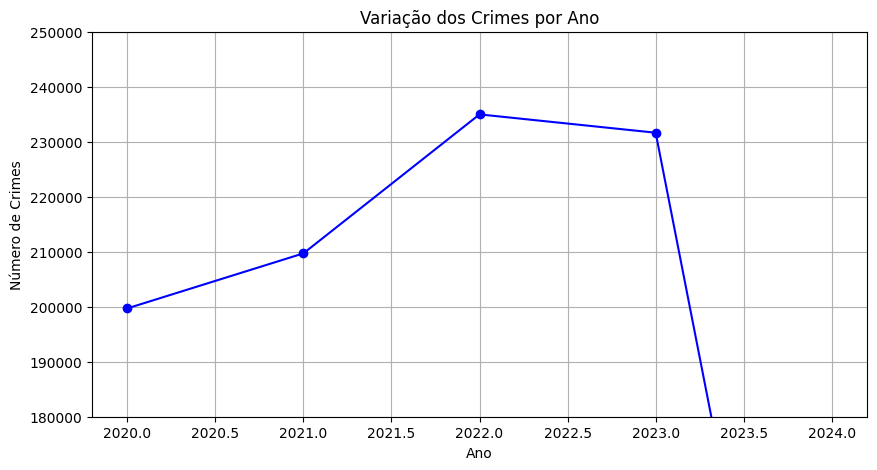

In [50]:
# Contar o número de crimes por ano
df_crime_year = df_new.groupBy("Ano").agg(count("*").alias("Crime_Count"))

# Ordenar os anos em ordem crescente
df_crime_year = df_crime_year.orderBy("Ano")

# Converter para Pandas para visualização
df_pandas = df_crime_year.toPandas()

# Criar gráfico de linha para mostrar a tendência ao longo dos anos
plt.figure(figsize=(10, 5))
plt.ylim(180000, 250000)
plt.plot(df_pandas["Ano"], df_pandas["Crime_Count"], marker="o", linestyle="-", color="blue")
plt.xlabel("Ano")
plt.ylabel("Número de Crimes")
plt.title("Variação dos Crimes por Ano")
plt.grid(True)
plt.show()

- **Tendência Geral dos Crimes por Ano:** O gráfico mostra a variação do número de crimes registados ao longo dos anos, evidenciando um crescimento entre 2020 e 2022, seguido de uma estabilização em 2023;

- **Redução Abrupta em 2024:** Nota-se uma queda acentuada no número de crimes registados em 2024. No entanto, essa redução pode não refletir uma tendência real, mas sim o fato de que os dados para esse ano podem estar incompletos. Como a análise considera apenas os registos disponíveis, a queda expressiva em 2024 pode ser temporária e necessita de confirmação com dados futuros.

### Distribuição de crimes por dia da semana

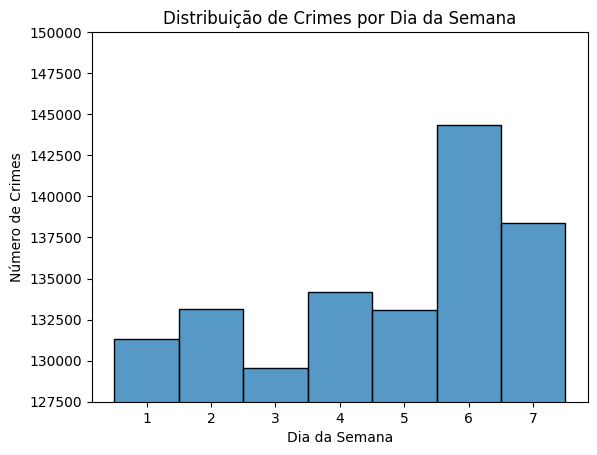

In [51]:
# Converter o DataFrame Pyspark para pandas.
# Apenas a coluna "DayOfweek" é selecionada para a análise
df_pandas = df_encoded.select("DayOfWeek").toPandas()

# Criar um histograma da distribuição de crimes por dia da semana.
# Utilizamos o "bins=7" para garantir um intervalo discreto para os sete dias da semana
sns.histplot(df_pandas, x="DayOfWeek", bins=7, discrete=True)

# Definição do limites do eixo y para melhor visualização dos dados
plt.ylim(127500, 150000)

#Etiquetas dos eixos e título do gráfico
plt.xlabel("Dia da Semana")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Dia da Semana")
plt.show()

**Distribuição dos Crimes:**

* **Dias com Maior Criminalidade:** Os dias 6 e 7 apresentam o maior número de crimes, correspondendo a sábado e domingo;
* **Tendência ao Longo da Semana:** Há uma redução dos crimes nos restantes dias, comparativamente ao fim de semana.
* **Possíveis Causas:** O aumento da criminalidade nesses dias pode estar relacionado com maior circulação de pessoas nas ruas e a frequência em bares noturnos.

Recomendação: Reforçar a presença das forças de segurança na cidade de Los Angeles nesses dias para mitigar a criminalidade.

### Distribuição de crimes a diferentes horas do dia

In [52]:
#  Contar crimes por hora do dia
df_crime_hour = df_new.groupBy("Hora").agg(count("*").alias("Crime_Count"))

#  Ordenar do horário com mais crimes para o menor
df_crime_hour = df_crime_hour.orderBy(col("Crime_Count").desc())

#  Mostrar os horários com mais crimes
df_crime_hour.show(10)

+----+-----------+
|Hora|Crime_Count|
+----+-----------+
|  12|      63876|
|  18|      56170|
|  17|      55099|
|  20|      52742|
|  19|      52080|
|  16|      49777|
|  15|      49464|
|  21|      47810|
|  14|      46245|
|  22|      46079|
+----+-----------+
only showing top 10 rows



In [53]:
# Criar um índice numérico para cada período
df_crime_period = df_new.withColumn(
    "Order_Index",
    when(col("Hora_Categoria") == "Madrugada", 1)
    .when(col("Hora_Categoria") == "Manhã", 2)
    .when(col("Hora_Categoria") == "Tarde", 3)
    .otherwise(4)  # "Noite"
)

# Ordenar cronologicamente
df_crime_period = df_crime_period.orderBy("Order_Index").drop("Order_Index")

# Contar o número de crimes por período do dia
df_crime_period = df_new.groupBy("Hora_Categoria").agg(count("*").alias("Crime_Count"))

# Ordenar os períodos pelo número de crimes
df_crime_period = df_crime_period.orderBy(col("Crime_Count").desc())

# Mostrar períodos do dia com mais crimes
df_crime_period.show()

+--------------+-----------+
|Hora_Categoria|Crime_Count|
+--------------+-----------+
|         Tarde|     307179|
|         Noite|     294619|
|         Manhã|     212738|
|     Madrugada|     129678|
+--------------+-----------+



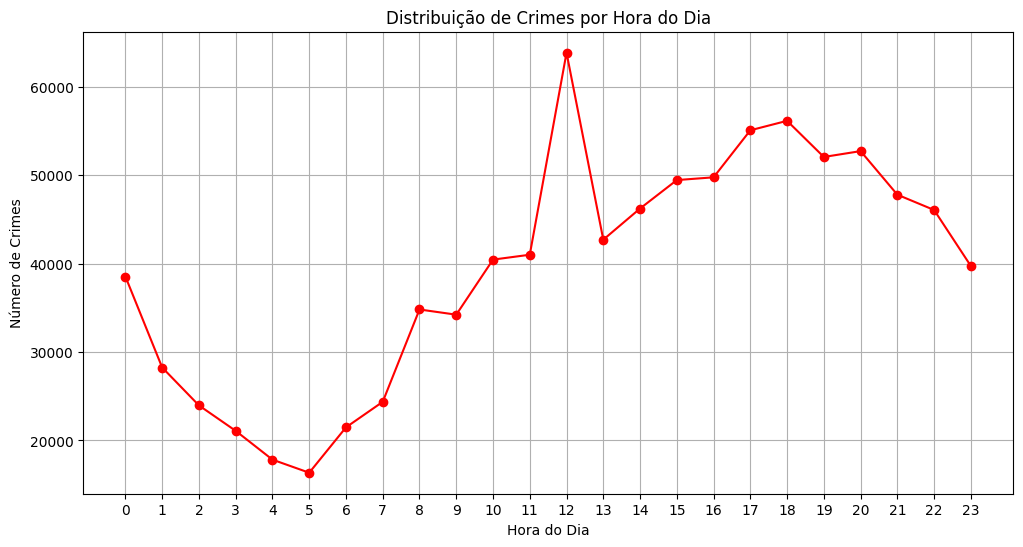

In [54]:
# Ordenar as horas corretamente de 0 a 23
df_crime_hour = df_crime_hour.orderBy(col("Hora").asc())

# Converter para Pandas
df_pandas = df_crime_hour.toPandas()

# Criar gráfico
plt.figure(figsize=(12,6))
plt.plot(df_pandas["Hora"], df_pandas["Crime_Count"], marker="o", linestyle="-", color="red")
plt.xlabel("Hora do Dia")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Hora do Dia")

# Ajustar os rótulos do eixo x (para garantir que as horas aparecem corretamente)
plt.xticks(range(0, 24))

# Adicionar grade para melhor visualização
plt.grid()

# Exibir gráfico
plt.show()

### **Análise da Criminalidade por Horário**  

- **Padrão Observado:** Verifica-se um **pico de criminalidade por volta das 12h**, com valores elevados durante a tarde e início da noite. Já **durante a madrugada, os valores são significativamente mais baixos**;

- **Possíveis Explicações:** Esse padrão pode estar associado ao **aumento da circulação de pessoas nas ruas**, maior fluxo em áreas comerciais e deslocamentos para casa ou lazer;  
- **Relevância da Análise:** Compreender os horários de maior criminalidade permite otimizar a alocação de recursos das forças de segurança, reforçando a vigilância nos períodos mais críticos.

## 5.3 Características das vítimas

### Por género

In [55]:
#Contar o número de crimes por género da vítima
df_crime_sex = df_new.groupBy("Victim_Sex").agg(count("*").alias("Crime_Count"))
df_crime_sex = df_crime_sex.orderBy("Crime_Count", ascending=False)

df_crime_sex.show()

#Converter para pandas
df_pandas_sex = df_crime_sex.toPandas()

+----------+-----------+
|Victim_Sex|Crime_Count|
+----------+-----------+
|         M|     385764|
|         F|     344144|
|         X|     214306|
+----------+-----------+



<ipython-input-56-112ca959b22e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Victim_Sex", y="Crime_Count", data=df_pandas_sex, palette="Blues_r")


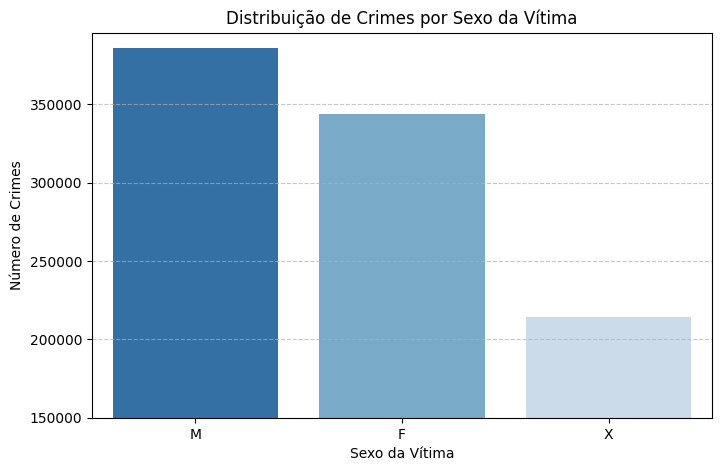

In [56]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Victim_Sex", y="Crime_Count", data=df_pandas_sex, palette="Blues_r")

plt.xlabel("Sexo da Vítima")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Sexo da Vítima")
plt.ylim(150000, df_pandas_sex["Crime_Count"].max() + 10000)  # Ajuste do eixo Y

plt.xticks(rotation=0)  # Garante que os rótulos fiquem visíveis
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Por étnia

<ipython-input-57-9c7f90f0afd3>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Victim_Descent", y="Crime_Count", data=df_crime_ethnicity_pd, palette="Blues_r")


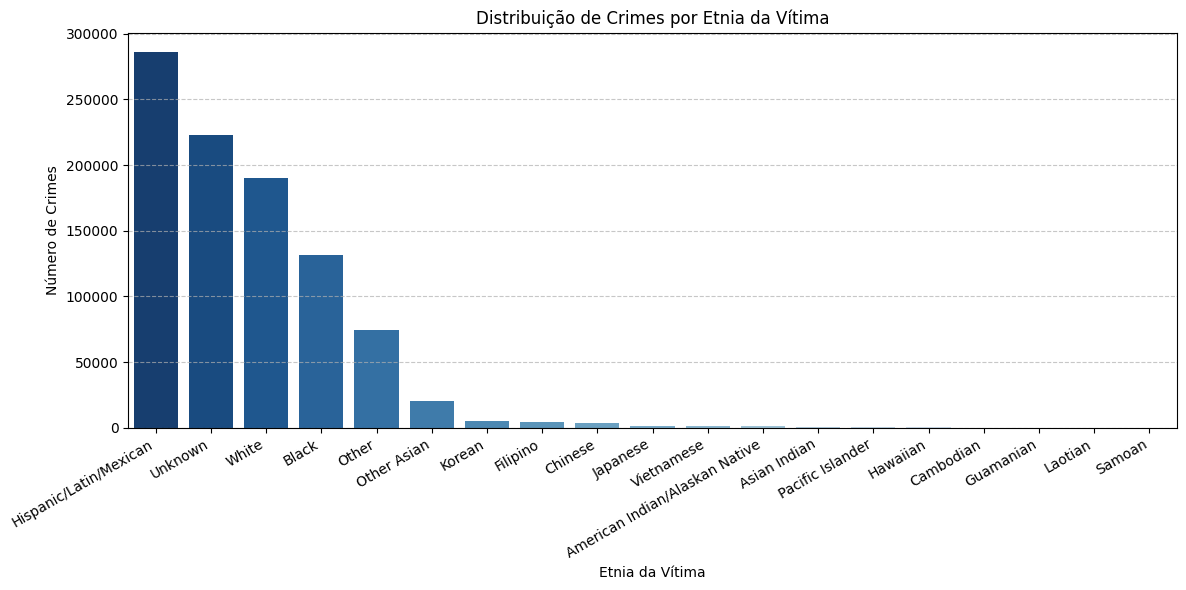

In [57]:
# Agrupar crimes por etnia da vítima
df_crime_ethnicity = df_new.groupBy("Victim_Descent").count().withColumnRenamed("count", "Crime_Count")

# Ordenar os dados do maior para o menor
df_crime_ethnicity = df_crime_ethnicity.orderBy("Crime_Count", ascending=False)

# Converter para Pandas DataFrame para visualização no Seaborn
df_crime_ethnicity_pd = df_crime_ethnicity.toPandas()

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="Victim_Descent", y="Crime_Count", data=df_crime_ethnicity_pd, palette="Blues_r")

plt.xlabel("Etnia da Vítima")
plt.ylabel("Número de Crimes")
plt.title("Distribuição de Crimes por Etnia da Vítima")

plt.xticks(rotation=30, ha="right")  # Ajusta rotação e alinhamento
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Evita sobreposição de elementos
plt.show()

### Análise

### **Distribuição de Crimes por Sexo da Vítima**
- **Tendência Principal:** Os homens (*M*) são as principais vítimas de crimes, seguidos pelas mulheres (*F*). A categoria *X*, que representa desconhecido ou não especificado, apresenta um número significativamente menor de registros;

- **Possível Explicação:** Essa distribuição pode indicar que certos tipos de crimes afetam mais homens do que mulheres, ou pode refletir um viés na forma como os crimes são reportados e registrados.

---

### **Distribuição de Crimes por Etnia da Vítima**
- **Observação Geral:** O gráfico mostra a quantidade de crimes cometidos contra vítimas de diferentes grupos étnicos;
- **Grupo Mais Afetado:** A categoria *Hispanic/Latin/Mexican* lidera o número de ocorrências, seguida por *Unknown* (desconhecido), *White* e *Black*;

- **Categorias Menos Afetadas:** Grupos como *Samoan*, *Laotian*, *Guamanian* e *Hawaiian* apresentam um número muito baixo de registos;

- **Possível Explicação:** A predominância de certas categorias pode estar relacionada à distribuição demográfica da cidade, bem como a fatores socioeconómicos e padrões de criminalidade em áreas específicas;

- **Impacto para Políticas Públicas:** Esses dados podem ser úteis para direcionar recursos de segurança pública para grupos mais vulneráveis e entender melhor as disparidades na vitimização criminal.

## 5.4 Conclusões

Com base na análise exploratória dos dados criminais de Los Angeles, foram extraídas diversas informações relevantes sobre a distribuição dos crimes ao longo do tempo, das vítimas e das áreas mais afetadas.  

#### **1. Tipos de Crimes Mais Comuns**  
- O **roubo de veículos** foi identificado como o crime mais recorrente, o que indica a necessidade de reforçar a segurança para evitar furtos e assaltos desse tipo.
- A distribuição dos códigos criminais sugeriu que determinados crimes mais graves apresentam padrões específicos em relação ao local e horário de ocorrência.

#### **2. Distribuição Geográfica**  
- As regiões com maior incidência criminal foram **Central, 77th Street e Pacific**, seguidas por Southwest e Hollywood. Isso sugere que áreas mais densamente povoadas ou turísticas podem estar mais sujeitas a crimes.  
- A análise por distrito policial indicou que o **distrito 162 registrou o maior número de crimes**, seguido de outros distritos urbanos com grande fluxo de pessoas.  

#### **3. Tendências Temporais**  
- Observou-se que os crimes apresentam um **pico ao meio-dia**, além de um aumento significativo durante a tarde e início da noite. Já durante a madrugada, a criminalidade atinge seus valores mais baixos.  
- A distribuição dos crimes ao longo da semana mostrou que **sextas-feiras e sábados** registram a maior incidência, possivelmente devido ao maior fluxo de pessoas em espaços públicos e eventos noturnos.  
- A análise por ano indicou uma **tendência de crescimento da criminalidade entre 2020 e 2022**, com uma ligeira queda em 2023. O número reduzido de ocorrências em 2024 provavelmente se deve à falta de registros completos para o ano.    

#### **4. Características das Vítimas**  
- A distribuição por sexo revelou que os **homens são mais frequentemente vítimas de crimes**, seguidos pelas mulheres, enquanto casos sem especificação do sexo são minoritários.  
- A análise por etnia destacou que a maior parte das vítimas pertence ao grupo **Hispanic/Latin/Mexican**, seguido por **White** e **Black**. Isso pode estar relacionado à composição demográfica da cidade e a fatores socioeconómicos.

# 6. Treino do modelo

### Criação de variáveis com melhor correlação com a variável alvo (Crime_Count)

A variável "Crime_Count" não possui atualmente uma correlação boa com nenhuma variável existente. Assim, vamos testar outra abordagem, introduzindo uma nova variável ao dataset.

In [81]:
df_new = df_new.withColumn("Crime_Zone_Multi",
    when(df_new["Crime_Count"] <= 800, 0)  # Baixa criminalidade
    .when((df_new["Crime_Count"] > 800) & (df_new["Crime_Count"] <= 1300), 1)  # Média
    .when((df_new["Crime_Count"] > 1300) & (df_new["Crime_Count"] <= 1800), 2)  # Alta
    .otherwise(3)  # Muito alta
)

# Verificar a distribuição das classes
df_new.groupBy("Crime_Zone_Multi").count().show()

+----------------+------+
|Crime_Zone_Multi| count|
+----------------+------+
|               1|258739|
|               3|221857|
|               2|156567|
|               0|307051|
+----------------+------+



A variável "Crime_Zone_Multi" tem como objetivo dividir os crimes por 4 zonas de criminalidade: baixa, média, alta, e muito alta.

De seguida vamos fazer uma matriz de correlação para perceber se faz sentido agregá-la ao modelo. Caso exista correlação com "Crime_Count" utilizamos, caso contrário descartamos.

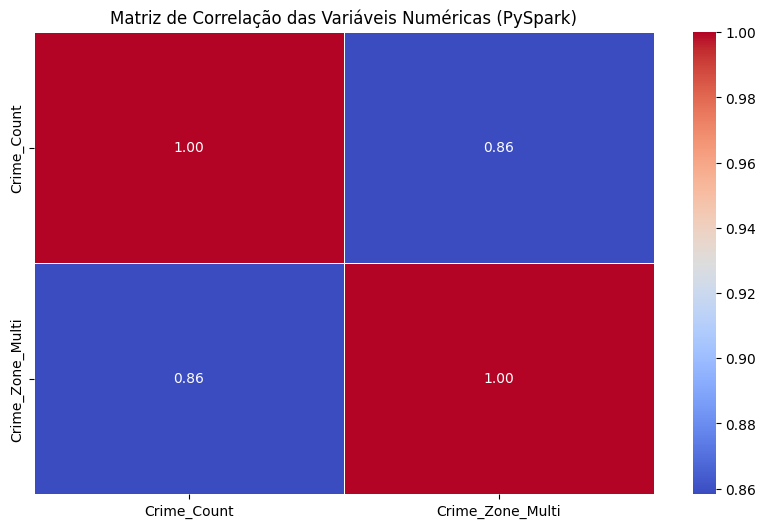

In [82]:
# Definir as colunas numéricas para análise de correlação
numeric_cols = ["Crime_Count", "Crime_Zone_Multi"]

# Criar o vetor de características para a correlação
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df_new).select(vector_col)

# Calcular a matriz de correlação
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Converter para array numpy
corr_array = np.array(correlation_matrix.toArray())

# Criar o heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Matriz de Correlação das Variáveis Numéricas (PySpark)")
plt.show()

Conforme observado, existe uma correlação de 86% com a variável "Crime_Count". Assim, vamos utilizá-la no modelo.

### Conversão dos formatos de Data e Hora para um formato suportado pelo vector assembler

O Vector Assembler apenas aceita formatos numéricos, nos formatos Integer, Float ou Vector. Como as colunas de data e hora não estão nesse formato, decidimos tranformar a coluna de data em número de dias desde 01.01.2020; e a coluna de horas em minutos.

In [58]:
# Garantir que a coluna Date_Occurred está no formato correto
df_new = df_new.withColumn("Date_Occurred", to_date(col("Date_Occurred"), "yyyy-MM-dd"))

# Definir a base para contagem de dias (2020-01-01)
base_date = to_date(lit("2020-01-01"))

# Criar a coluna com a diferença de dias desde 2020-01-01
df_new = df_new.withColumn("Date_Occurred_Num", datediff(col("Date_Occurred"), base_date))

# Converter "Time_Occurred" (HH:MM) para minutos desde a meia-noite
df_new = df_new.withColumn("Hour", hour(col("Time_Occurred")))  # Extrai hora
df_new = df_new.withColumn("Minute", minute(col("Time_Occurred")))  # Extrai minutos
df_new = df_new.withColumn("Time_Occurred_Num", col("Hour") * 60 + col("Minute"))  # Converte para minutos totais

# Remover colunas auxiliares (opcional)
df_new = df_new.drop("Hour", "Minute")

# Verificar se os valores foram gerados corretamente
df_new.select("Date_Occurred", "Date_Occurred_Num", "Time_Occurred", "Time_Occurred_Num").show(5)

+-------------+-----------------+-------------+-----------------+
|Date_Occurred|Date_Occurred_Num|Time_Occurred|Time_Occurred_Num|
+-------------+-----------------+-------------+-----------------+
|   2020-03-01|               60|        21:30|             1290|
|   2020-02-08|               38|        18:00|             1080|
|   2020-11-04|              308|        17:00|             1020|
|   2020-03-10|               69|        20:37|             1237|
|   2020-08-17|              229|        12:00|              720|
+-------------+-----------------+-------------+-----------------+
only showing top 5 rows



In [60]:
# Selecionar apenas as colunas desejadas
#selected_columns = ["Crime_Code", "Date_Occurred_Num", "Time_Occurred_Num", "Area_Code", "Crime_Count", "Latitude", "Longitude"]

# Verificar se df_encoded é um DataFrame do PySpark
#from pyspark.sql import DataFrame as PySparkDataFrame

#if isinstance(df_encoded, PySparkDataFrame):
    #df_encoded = df_encoded.select(*selected_columns)
    #df_encoded = df_encoded.toPandas()
#else:
    # Caso df_encoded já seja um DataFrame Pandas
    #df_encoded = df_encoded[selected_columns]

# Guardar num ficheiro CSV
#file_path = "/content/Crime_Data_Selected_final.csv"
#df_encoded.to_csv(file_path, index=False)

# Permitir o download do ficheiro
#from google.colab import files
#files.download(file_path)


In [62]:
num_cols = ["Time_Occurred_Num", "Crime_Code", "Premise_Code", "Area_Code"]

assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_final = assembler.transform(df_new)

df_final = df_final.select("Crime_Count", "features")

print(f"🚀 df_final tem {df_final.count()} linhas!")
df_final.show(5, truncate=False)

🚀 df_final tem 944214 linhas!
+-----------+--------------------------------------------+
|Crime_Count|features                                    |
+-----------+--------------------------------------------+
|396        |[2020.0,2.0,2.0,0.0,1380.0,813.0,501.0,16.0]|
|1487       |[2020.0,9.0,2.0,0.0,1260.0,820.0,101.0,15.0]|
|839        |[2020.0,6.0,3.0,0.0,1260.0,510.0,101.0,13.0]|
|612        |[2020.0,12.0,3.0,0.0,840.0,341.0,203.0,1.0] |
|612        |[2020.0,9.0,1.0,1.0,1.0,354.0,502.0,1.0]    |
+-----------+--------------------------------------------+
only showing top 5 rows



In [63]:
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)
print("🔥 Dados de treino e teste prontos!")

🔥 Dados de treino e teste prontos!


# 7. Modelos

In [64]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="Crime_Count", numTrees=100, maxDepth=5)
model_rf = rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)

In [65]:
predictions_rf.select("Crime_Count", "prediction").show(10)

+-----------+------------------+
|Crime_Count|        prediction|
+-----------+------------------+
|          1|1179.8906951796757|
|          1|1251.2707414926213|
|          1|1225.7188521627922|
|          1|1223.5970652844946|
|          1|1254.8703260801956|
|          1| 1278.777131380555|
|          1|1253.4355284926057|
|          1|1237.5618337346964|
|          1|1248.5546976695196|
|          1|1244.7556114448205|
+-----------+------------------+
only showing top 10 rows



In [66]:
from pyspark.ml.evaluation import RegressionEvaluator

# Calcular R² (Coeficiente de Determinação)
evaluator_r2 = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="r2")
r2_test = evaluator_r2.evaluate(predictions_rf)

# Calcular RMSE (Erro Médio Quadrático)
evaluator_rmse = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="rmse")
rmse_test = evaluator_rmse.evaluate(predictions_rf)

print(f"R² no teste: {r2_test}")
print(f"RMSE no teste: {rmse_test}")

R² no teste: 0.11318106581674803
RMSE no teste: 814.1687221541602


In [67]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="Crime_Count", maxIter=50, maxDepth=5)
model_gbt = gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)

In [68]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Crime_Count", regParam=0.1, elasticNetParam=0.5)
model_lr = lr.fit(train_data)
predictions_lr = model_lr.transform(test_data)

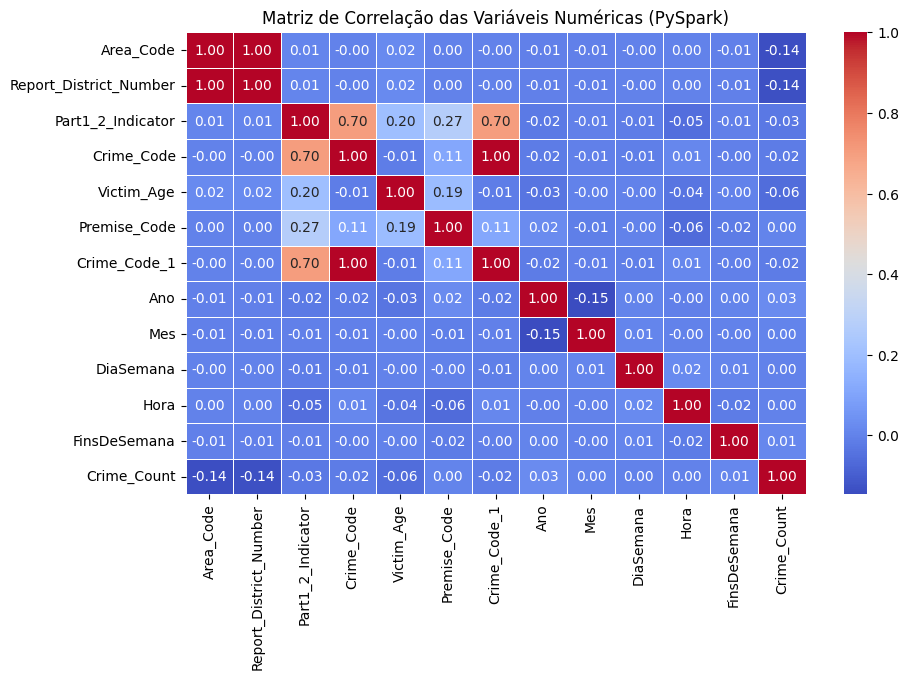

In [69]:
# Definir as colunas numéricas para análise de correlação
numeric_cols = ["Area_Code", "Report_District_Number", "Part1_2_Indicator", "Crime_Code", "Victim_Age", "Premise_Code", "Crime_Code_1", "Ano", "Mes","DiaSemana","Hora", "FinsDeSemana", "Crime_Count"]

# Criar o vetor de características para a correlação
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df_new).select(vector_col)

# Calcular a matriz de correlação
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Converter para array numpy
corr_array = np.array(correlation_matrix.toArray())

# Criar o heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Matriz de Correlação das Variáveis Numéricas (PySpark)")
plt.show()

In [70]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Criar um vetor com latitude e longitude
geo_features = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="geo_vector")
df_1 = geo_features.transform(df_new)

# Aplicar K-Means para criar regiões
kmeans = KMeans(featuresCol="geo_vector", predictionCol="region_cluster", k=5)  # Ajuste k conforme necessário
model_kmeans = kmeans.fit(df_1)
df_1 = model_kmeans.transform(df_1)

In [71]:
df_new.groupBy("Crime_Count").count().orderBy("Crime_Count").show()


+-----------+-----+
|Crime_Count|count|
+-----------+-----+
|          1|   49|
|          2|   42|
|          3|    6|
|          4|    4|
|          6|   12|
|          7|    7|
|          8|    8|
|         12|   12|
|         18|   18|
|         20|   20|
|         23|   23|
|         24|   24|
|         25|   25|
|         26|   26|
|         28|   28|
|         32|   64|
|         33|   33|
|         35|   70|
|         37|   74|
|         40|   40|
+-----------+-----+
only showing top 20 rows



In [72]:
df_new = df_new.withColumn("Crime_Class",
    when(df_new["Crime_Count"] <= 3, "Muito Baixo")
    .when((df_new["Crime_Count"] > 3) & (df_new["Crime_Count"] <= 15), "Baixo")
    .when((df_new["Crime_Count"] > 15) & (df_new["Crime_Count"] <= 30), "Médio")
    .when((df_new["Crime_Count"] > 30) & (df_new["Crime_Count"] <= 50), "Alto")
    .otherwise("Muito Alto")
)

In [73]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Crime_Class", outputCol="Crime_Class_Index")
df_new = indexer.fit(df_new).transform(df_new)

In [74]:
# Criar lista de features incluindo a nova variável Crime_Class_Index
feature_cols = ["Crime_Class_Index", "Time_Occurred_Num", "Crime_Code", "Premise_Code", "Area_Code", "Ano", "Mes", "DiaSemana", "FinsDeSemana"]

# Criar vetor de features para correlação
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_corr")
df_new = assembler.transform(df_new)

In [75]:
correlation_matrix = Correlation.corr(df_new, "features_corr").head()[0]
print("Matriz de Correlação:\n", correlation_matrix)


Matriz de Correlação:
 DenseMatrix([[ 1.00000000e+00, -1.93712915e-03, -4.94009967e-04,
              -8.54726334e-03,  2.57898776e-03, -6.92166343e-04,
              -9.28318506e-04,  7.90784711e-04,  1.68684562e-03],
             [-1.93712915e-03,  1.00000000e+00,  1.52042564e-02,
              -6.06813501e-02, -5.21903710e-04, -2.33339412e-03,
              -3.26413843e-04,  2.10836526e-02, -1.88125114e-02],
             [-4.94009967e-04,  1.52042564e-02,  1.00000000e+00,
               1.09425695e-01, -9.58611584e-04, -1.83272072e-02,
              -6.33570555e-03, -7.65868418e-03, -4.08907672e-03],
             [-8.54726334e-03, -6.06813501e-02,  1.09425695e-01,
               1.00000000e+00,  2.55795495e-04,  2.41531521e-02,
              -8.65743625e-03, -1.93223356e-03, -1.95765153e-02],
             [ 2.57898776e-03, -5.21903710e-04, -9.58611584e-04,
               2.55795495e-04,  1.00000000e+00, -7.45324186e-03,
              -5.41526820e-03, -2.65185670e-03, -5.56025924e-03

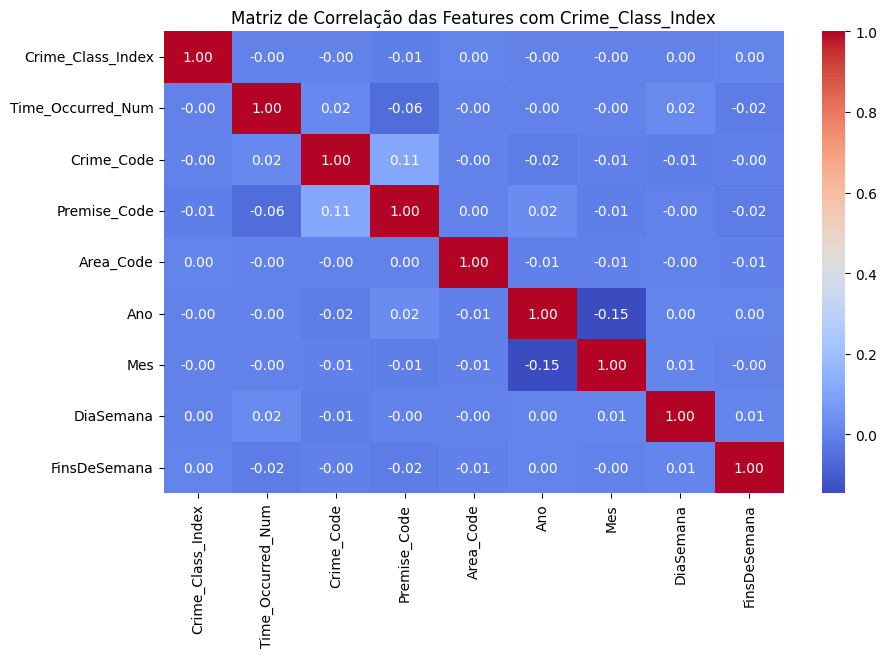

In [76]:
# Converter a matriz para um DataFrame Pandas
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), index=feature_cols, columns=feature_cols)

# Criar um heatmap de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação das Features com Crime_Class_Index")
plt.show()

In [77]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

geo_features = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="geo_vector")
df_new = geo_features.transform(df_new)

kmeans = KMeans(featuresCol="geo_vector", predictionCol="region_cluster", k=5)
model_kmeans = kmeans.fit(df_new)
df_new = model_kmeans.transform(df_new)

In [78]:
# Adicionar `region_cluster` na lista de features
feature_cols = ["region_cluster", "Crime_Class_Index", "Time_Occurred_Num", "Crime_Code", "Premise_Code", "Area_Code", "Ano", "Mes", "DiaSemana", "FinsDeSemana"]

# Criar vetor de features para correlação
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_corre")
df_new = assembler.transform(df_new)

# Calcular matriz de correlação
correlation_matrix = Correlation.corr(df_new, "features_corre").head()[0]
print("Matriz de Correlação:\n", correlation_matrix)

Matriz de Correlação:
 DenseMatrix([[ 1.00000000e+00,  8.99108682e-03,  2.38299453e-03,
              -4.44134249e-03,  4.09837989e-02,  5.88854418e-02,
              -3.13113629e-03, -1.28174253e-03,  1.04570113e-03,
              -5.69220383e-03],
             [ 8.99108682e-03,  1.00000000e+00, -1.93712915e-03,
              -4.94009967e-04, -8.54726334e-03,  2.57898776e-03,
              -6.92166343e-04, -9.28318506e-04,  7.90784711e-04,
               1.68684562e-03],
             [ 2.38299453e-03, -1.93712915e-03,  1.00000000e+00,
               1.52042564e-02, -6.06813501e-02, -5.21903710e-04,
              -2.33339412e-03, -3.26413843e-04,  2.10836526e-02,
              -1.88125114e-02],
             [-4.44134249e-03, -4.94009967e-04,  1.52042564e-02,
               1.00000000e+00,  1.09425695e-01, -9.58611584e-04,
              -1.83272072e-02, -6.33570555e-03, -7.65868418e-03,
              -4.08907672e-03],
             [ 4.09837989e-02, -8.54726334e-03, -6.06813501e-02,
    

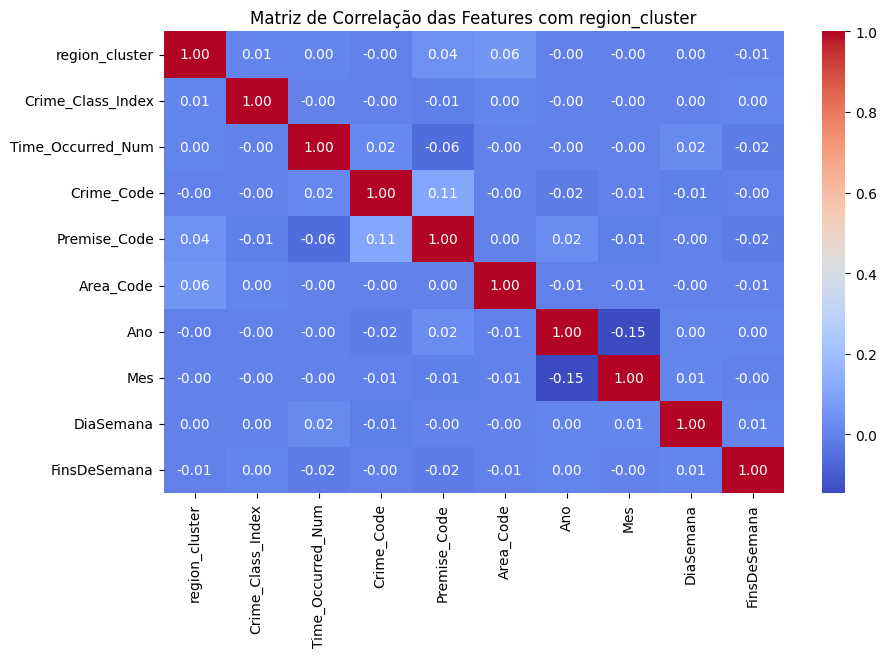

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Converter matriz de correlação para Pandas
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), index=feature_cols, columns=feature_cols)

# Criar o gráfico de heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação das Features com region_cluster")
plt.show()

In [80]:
df_new.groupBy("region_cluster").agg({"Crime_Count": "avg"}).orderBy("region_cluster").show()

+--------------+------------------+
|region_cluster|  avg(Crime_Count)|
+--------------+------------------+
|             0|1419.5117391540916|
|             1| 1566.958480565371|
|             2|1040.4561685896824|
|             3|1058.7105639434844|
|             4|1457.5416160142638|
+--------------+------------------+

